In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
REPORT_PATH = './%s/DiseaseReports.tsv'
LOG_PATH = './%s/patterns_of_life.log'
CHAR_PATH = './%s/AgentCharacteristicsTable.tsv'

In [12]:
def process_raw_data_files(datafolder, mapfolder):
    
    # process raw data
    raw_disease_reports = pd.read_csv(REPORT_PATH%datafolder, sep='\t|,', engine='python')
    region = [int(r[1:]) for r in raw_disease_reports['[regionId']]
    raw_disease_reports['regionId'] = region
    regions = raw_disease_reports['regionId'].unique()
    
    # find the considered single bias & population in each region
    biasTypes = ''
    population = []
    for line in open(LOG_PATH%datafolder).readlines():
        if 'Considered single bias types' in line:
            biasTypes = line.split(':')[-1].strip().split(', ')
        if 'Number of agents in Region' in line:
            population.append(int(line.split(': ')[-1]))
    singleBias = {}
    for bias in biasTypes:
        singleBias[bias] = []
    
    # convert Str type of reports into List of booleans
    #  to represent the single bias reports
    for report in raw_disease_reports['Report(Single)]']:
        for bias in biasTypes:
            singleBias[bias].append(bias in report)
    for bias in biasTypes:
        raw_disease_reports[bias] = singleBias[bias]
    
    # Count total number of infected agents in each region
    #  Also count the reported cases in each senario
    data_for_plot = raw_disease_reports[raw_disease_reports['diseaseStatus'] == 'Infectious']    
    data_for_plot = data_for_plot[['step','agentId','regionId','Report(Component)']+biasTypes]

    count_reports = []
    labels = ['regionId','# Real','# Component'] + ['# '+bias for bias in biasTypes]

    for rid in regions:
        rline = [rid]
        rdata = data_for_plot[data_for_plot['regionId'] == rid]
        rline.append(len(rdata))
        rline.append(len(rdata[rdata['Report(Component)'] == True]))
        for bias in biasTypes:
            rline.append(len(rdata[rdata[bias] == True]))
        count_reports.append(rline)
    report_summary = pd.DataFrame.from_records(count_reports, columns = labels)
    
    # Calculate the reporting rate
    report_summary['population'] = population
    for i in range(2, len(labels)):
        report_summary[labels[i].replace('#','%')] = report_summary[labels[i]]/report_summary['population']
    report_summary = report_summary.fillna(0)
    
    # Generat geo pandas contain census data and reporting rate
    shapefile = '../%s/region_census.shp'%mapfolder
    geo_df = gpd.read_file(shapefile)
    geo_df['Age >= 50'] = geo_df['AgeGroup7'] + geo_df['AgeGroup8'] +geo_df['AgeGroup9']
    geo_df['Income >= 50k'] = geo_df['IndiInc3'] + geo_df['IndiInc4'] + geo_df['IndiInc5']
    geo_df['Education > High School'] = geo_df['EduLevel3'] + geo_df['EduLevel4']
    geo_df['Race White'] = geo_df['Race0']
    geo_df['Race Not White'] = 1-geo_df['Race0']
    geo_df['Female'] = 1-geo_df['Male']
    percent_report_labels = [labels[i].replace('#','%') for i in range(2, len(labels))]
    for l in percent_report_labels:
        geo_df[l] = report_summary[l]
    geo_df = geo_df[['TotPop','geometry','id','Age >= 50','Male','Female','Education > High School','Income >= 50k','Race White','Race Not White'] + percent_report_labels]
    geo_df['# Real'] = report_summary['# Real']
    return report_summary, geo_df

In [13]:
def generat_plot(datafolder, mapfolder, columnname,vizfolder, filename, save = True):
    vizpath = '../viz/%s/'
    if not os.path.exists('../viz'):
        os.mkdir('../viz')
    if not os.path.exists(vizpath%vizfolder):
        os.mkdir(vizpath%vizfolder)
    _, geo_pd = process_raw_data_files(datafolder, mapfolder)
    fig, ax = plt.subplots(1, figsize=(5,3))
    geo_pd.plot(column=columnname, cmap='Blues', linewidth=1, ax=ax, edgecolor='0.9', legend=True)
    ax.axis('off')
    if save:
        fig.savefig(vizpath%vizfolder+filename, bbox_inches='tight')
        plt.close()

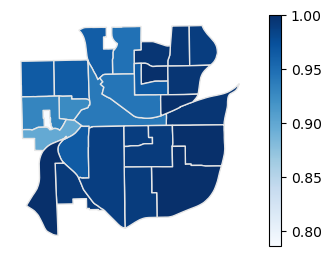

In [14]:
report_summary,geo_df = process_raw_data_files('atl-80', 'atlanta')
geo_df['% real'] = report_summary['# Real']/report_summary['population']
fig, ax = plt.subplots(1, figsize=(5,3))
geo_df.plot(column='% real', cmap='Blues', linewidth=1, ax=ax, edgecolor='0.9', legend=True)
ax.axis('off')
fig.savefig('../viz/atl/percent_case.png', bbox_inches='tight')

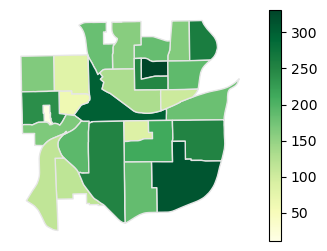

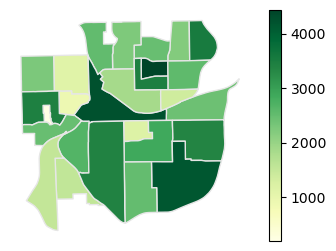

In [21]:
totalPopOverRegions = 67019 # manually calculated
report_summary,geo_df = process_raw_data_files('atl-80', 'atlanta')
geo_df['census pop'] = geo_df['TotPop'] * totalPopOverRegions
fig, ax = plt.subplots(1, figsize=(5,3))
geo_df.plot(column='# Real', cmap='YlGn', linewidth=1, ax=ax, edgecolor='0.9', legend=True)
ax.axis('off')
fig.savefig('../viz/atl/real_cases.png', bbox_inches='tight')

fig, ax = plt.subplots(1, figsize=(5,3))
geo_df.plot(column='census pop', cmap='YlGn', linewidth=1, ax=ax, edgecolor='0.9', legend=True)
ax.axis('off')
fig.savefig('../viz/atl/census_pop.png', bbox_inches='tight')


(738883.889929059, 745429.2471551637, 3733889.998107655, 3740189.469207843)

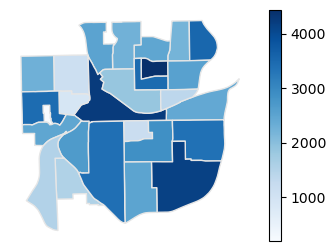

In [9]:
fig, ax = plt.subplots(1, figsize=(5,3))
geo_df.plot(column='census pop', cmap='Blues', linewidth=1, ax=ax, edgecolor='0.9', legend=True)
ax.axis('off')
fig.savefig('../viz/atl/multivariate.png', bbox_inches='tight')


In [15]:
generat_plot('atl-80', 'atlanta','Age >= 50', 'atl', 'census_age.png')
generat_plot('atl-80', 'atlanta','% Age', 'atl', 'age_80-20.png')
generat_plot('atl-70', 'atlanta','% Age', 'atl', 'age_70-30.png')
generat_plot('atl-60', 'atlanta','% Age', 'atl', 'age_60-40.png')
generat_plot('atl-50', 'atlanta','% Age', 'atl', 'age_50-50.png')

In [16]:
generat_plot('atl-80', 'atlanta','Income >= 50k', 'atl', 'census_income.png')
generat_plot('atl-80', 'atlanta','% Income', 'atl', 'income_80-20.png')
generat_plot('atl-70', 'atlanta','% Income', 'atl', 'income_70-30.png')
generat_plot('atl-60', 'atlanta','% Income', 'atl', 'income_60-40.png')
generat_plot('atl-50', 'atlanta','% Income', 'atl', 'income_50-50.png')

In [17]:
generat_plot('atl-80', 'atlanta','Male', 'atl', 'census_male.png')
generat_plot('atl-80', 'atlanta','% Gender', 'atl', 'gender_80-20.png')
generat_plot('atl-70', 'atlanta','% Gender', 'atl', 'gender_70-30.png')
generat_plot('atl-60', 'atlanta','% Gender', 'atl', 'gender_60-40.png')
generat_plot('atl-50', 'atlanta','% Gender', 'atl', 'gender_50-50.png')

In [18]:
generat_plot('atl-80', 'atlanta','Race White', 'atl', 'census_race.png')
generat_plot('atl-80', 'atlanta','% Race', 'atl', 'race_80-20.png')
generat_plot('atl-70', 'atlanta','% Race', 'atl', 'race_70-30.png')
generat_plot('atl-60', 'atlanta','% Race', 'atl', 'race_60-40.png')
generat_plot('atl-50', 'atlanta','% Race', 'atl', 'race_50-50.png')

In [45]:
generat_plot('atl-80', 'atlanta','Race Not White', 'atl', 'census_race_rev.png')
generat_plot('atl-80', 'atlanta','Female', 'atl', 'census_female.png')

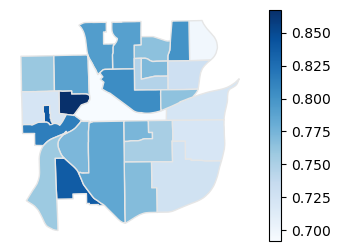

In [19]:
_,geo80 = process_raw_data_files('atl-80', 'atlanta')
_,geo70 = process_raw_data_files('atl-70', 'atlanta')
_,geo60 = process_raw_data_files('atl-60', 'atlanta')
_,geo50 = process_raw_data_files('atl-50', 'atlanta')


geo80['avg comp'] = (geo80['% Component'] + geo70['% Component'] + geo60['% Component'] + geo50['% Component'])/4
fig, ax = plt.subplots(1, figsize=(5,3))
geo80.plot(column='avg comp', cmap='Blues', linewidth=1, ax=ax, edgecolor='0.9', legend=True)
ax.axis('off')
fig.savefig('../viz/atl/multivariate.png', bbox_inches='tight')


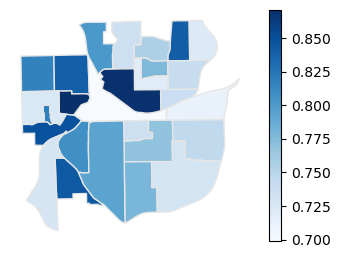

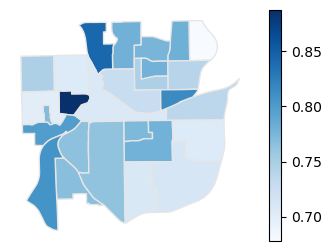

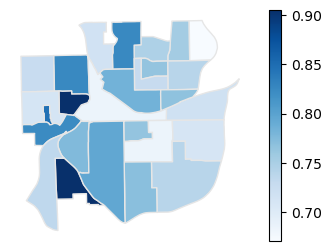

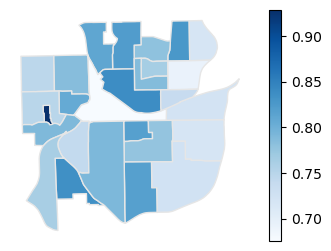

In [51]:
generat_plot('atl-80', 'atlanta','% Component', 'atl', 'multivariate.png', False)
generat_plot('atl-70', 'atlanta','% Component', 'atl', 'multivariate.png', False)
generat_plot('atl-60', 'atlanta','% Component', 'atl', 'multivariate.png', False)
generat_plot('atl-50', 'atlanta','% Component', 'atl', 'multivariate.png', False)

(738883.889929059, 745429.2471551637, 3733889.998107655, 3740189.469207843)

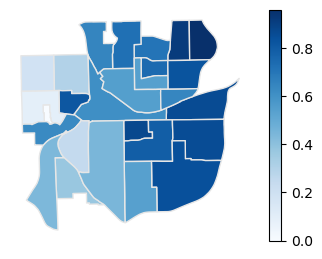

In [14]:
atl_report, atl_geo = process_raw_data_files('atlanta', 'atlanta')
fig, ax = plt.subplots(1, figsize=(5,3))
atl_geo.plot(column='Income >= 50k', cmap='Blues', linewidth=1, ax=ax, edgecolor='0.9', legend=True)
ax.axis('off')
# fig.savefig('example.png')

(738883.889929059, 745429.2471551637, 3733889.998107655, 3740189.469207843)

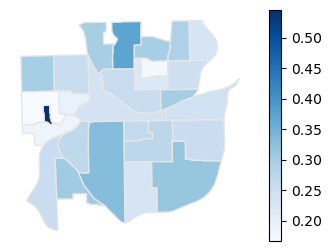

In [27]:
atl_report, atl_geo = process_raw_data_files('atl-80', 'atlanta')
fig, ax = plt.subplots(1, figsize=(5,3))
atl_geo.plot(column='% Age', cmap='Blues', linewidth=1, ax=ax, edgecolor='0.9', legend=True)
ax.axis('off')

(738883.889929059, 745429.2471551637, 3733889.998107655, 3740189.469207843)

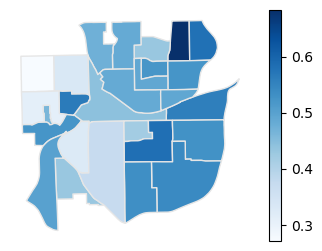

In [16]:
atl_report, atl_geo = process_raw_data_files('atl-70', 'atlanta')
fig, ax = plt.subplots(1, figsize=(5,3))
atl_geo.plot(column='% Income', cmap='Blues', linewidth=1, ax=ax, edgecolor='0.9', legend=True)
ax.axis('off')

(738883.889929059, 745429.2471551637, 3733889.998107655, 3740189.469207843)

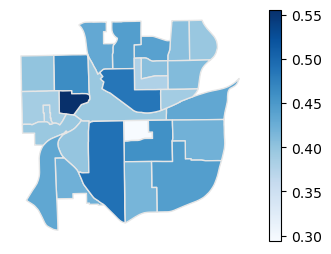

In [17]:
atl_report, atl_geo = process_raw_data_files('atl-60', 'atlanta')
fig, ax = plt.subplots(1, figsize=(5,3))
atl_geo.plot(column='% Age', cmap='Blues', linewidth=1, ax=ax, edgecolor='0.9', legend=True)
ax.axis('off')

(738883.889929059, 745429.2471551637, 3733889.998107655, 3740189.469207843)

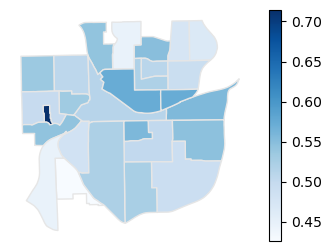

In [18]:
atl_report, atl_geo = process_raw_data_files('atl-50', 'atlanta')
fig, ax = plt.subplots(1, figsize=(5,3))
atl_geo.plot(column='% Age', cmap='Blues', linewidth=1, ax=ax, edgecolor='0.9', legend=True)
ax.axis('off')

In [4]:
sanfran_report, sanfran_geo = process_raw_data_files('sanfran', 'san-fran-v2')

(-2661931.310128629, -2655439.463948181, 4823247.4313851, 4827774.045947018)

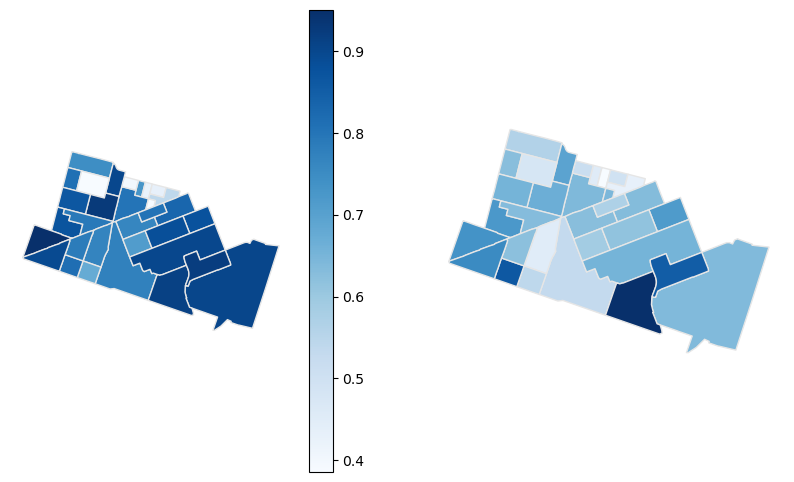

In [5]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
sanfran_geo.plot(column='Income >= 50k', cmap='Blues', linewidth=1, ax=ax[0], edgecolor='0.9', legend=True)
sanfran_geo.plot(column='% Income', cmap='Blues', linewidth=1, ax=ax[1], edgecolor='0.9')

ax[0].axis('off')
ax[1].axis('off')

(-2661931.310128629, -2655439.463948181, 4823247.4313851, 4827774.045947018)

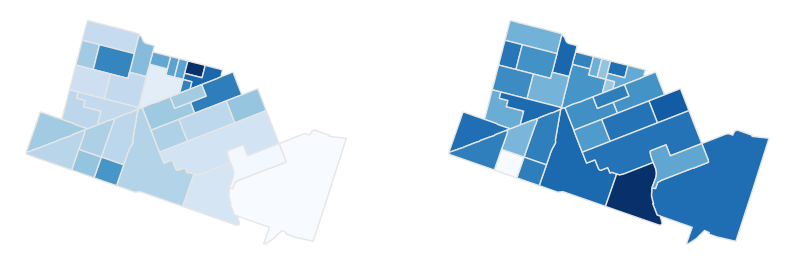

In [6]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
sanfran_geo.plot(column='Age >= 50', cmap='Blues', linewidth=1, ax=ax[0], edgecolor='0.9')
sanfran_geo.plot(column='% Component', cmap='Blues', linewidth=1, ax=ax[1], edgecolor='0.9')

ax[0].axis('off')
ax[1].axis('off')

In [8]:
atl_report, atl_geo = process_raw_data_files('atlanta', 'atlanta')

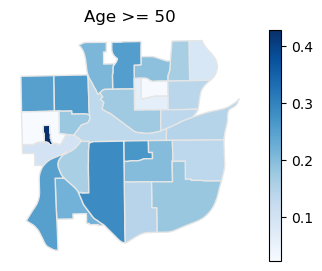

In [29]:
fig, ax = plt.subplots(1, figsize=(5,3))
atl_geo.plot(column='Age >= 50', cmap='Blues', linewidth=1, ax=ax, edgecolor='0.9', legend=True)
ax.set_title('Age >= 50')
ax.axis('off')
fig.savefig('example.png')

(738883.889929059, 745429.2471551637, 3733889.998107655, 3740189.469207843)

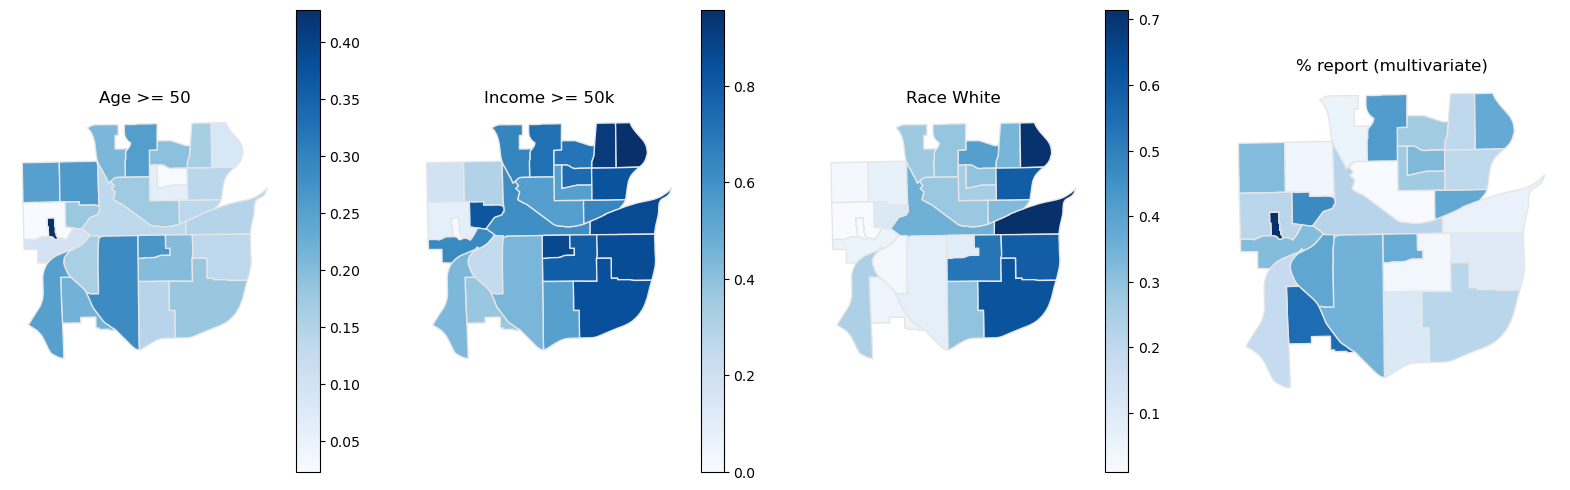

In [27]:
fig, ax = plt.subplots(1,4, figsize=(20,6))
atl_geo.plot(column='Age >= 50', cmap='Blues', linewidth=1, ax=ax[0], edgecolor='0.9', legend=True)
ax[0].set_title('Age >= 50')
atl_geo.plot(column='Income >= 50k', cmap='Blues', linewidth=1, ax=ax[1], edgecolor='0.9', legend=True)
ax[1].set_title('Income >= 50k')
#atl_geo.plot(column='Male', cmap='Blues', linewidth=1, ax=ax[2], edgecolor='0.9', legend=True)
#ax[2].set_title('Male')
atl_geo.plot(column='Race White', cmap='Blues', linewidth=1, ax=ax[2], edgecolor='0.9', legend=True)
ax[2].set_title('Race White')
atl_geo.plot(column='% Component', cmap='Blues', linewidth=1, ax=ax[3], edgecolor='0.9')
ax[3].set_title('% report (multivariate)')

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
#ax[4].axis('off')